In [235]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter("ignore") 

from matplotlib import test
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from collections import Counter
from pretty_confusion_matrix import pp_matrix #pip install pretty_confusion_matrix

import json
import matplotlib.pyplot as plt
import gzip
import pandas as pd
import copy
import os
import numpy as np
from fpdf import FPDF #pip install fpdf2 #pip install fpdf
from PIL import Image

# Part 1

In [236]:
sentiments = []
emotions = []
comments = []

commentsTrainVector = None
commentsTestVector = None

In [237]:
#1.2
emotionsGZIP = gzip.open("./goemotions.json.gz", "rb")
emotionsJSON = json.load(emotionsGZIP)

In [238]:
def createPieChart(dict, dictName):
    labels = []
    values = []
    for x,y in dict.items():
        labels.append(x)
        values.append(y)
    plt.pie(values, labels=labels, autopct=lambda p:f'{p:.2f}%, {p*sum(values)/100 :.0f}')
    plt.savefig(fname='./graphs/'+dictName+'.pdf', format='pdf')
    plt.clf()
    

In [239]:
#1.3
for value in emotionsJSON:
        emotions.append(value[1])
        sentiments.append(value[2])
        comments.append(value[0])

createPieChart(Counter(emotions), 'emotions_with_values')
createPieChart(Counter(sentiments), 'sentiments_with_values')

<Figure size 640x480 with 0 Axes>

# Part 2

In [240]:
#2.1
vectorizer = CountVectorizer()
X  = vectorizer.fit(comments)
print("Vocabulary size: ", len(X.vocabulary_))

Vocabulary size:  30449


In [241]:
#2.2
comments_train, comments_test, sentiments_train, sentiments_test, emotions_train, emotions_test = train_test_split(comments, sentiments, emotions, test_size=0.2, random_state=0)

## 2.3

In [242]:
#2.3
vectorizer = CountVectorizer()
commentsTrainVector = vectorizer.fit_transform(comments_train)
commentsTestVector = vectorizer.transform(comments_test)


def getBaseClassifiersPredictions(classifier, commentsTrainVector, commentsTestVector, sentiments_train, emotions_train):

    #emotions
    classifier.fit(commentsTrainVector, emotions_train)
    emotions_classifier = copy.deepcopy(classifier)
    emotions_pred = classifier.predict(commentsTestVector)
    print(emotions_pred)

    #sentiments
    classifier.fit(commentsTrainVector, sentiments_train)
    sentiments_classifier = copy.deepcopy(classifier)
    sentiments_pred = classifier.predict(commentsTestVector)
    print(sentiments_pred)

    return emotions_pred, sentiments_pred, emotions_classifier, sentiments_classifier

def getGridSearchWithModelAndParams(model, params, cvCount, jobs, commentsTrainVector, commentsTestVector, sentiments_train, emotions_train):
    #Setup GridSearch and hyperparams
    tunedClassifier = GridSearchCV(model, params, cv=cvCount, n_jobs=jobs)
    hyperparams = list(params.keys())
    hyperparamsWithParams = ['param_' + paramInList for paramInList in hyperparams]
    
    #emotions
    tunedClassifier.fit(commentsTrainVector, emotions_train)
    emotions_tunedClassifier = copy.deepcopy(tunedClassifier)
    emotions_cv_results = tunedClassifier.cv_results_
    df = pd.DataFrame(emotions_cv_results)
    
    emotions_pred = tunedClassifier.predict(commentsTestVector)
    
    print(df[hyperparamsWithParams])
    print(tunedClassifier.best_score_)
    print(tunedClassifier.best_params_)
    print(tunedClassifier.predict(commentsTestVector))

    #sentiments
    tunedClassifier.fit(commentsTrainVector, sentiments_train)
    sentiments_tunedClassifier = copy.deepcopy(tunedClassifier)
    sentiments_cv_results = tunedClassifier.cv_results_
    df = pd.DataFrame(sentiments_cv_results)

    sentiments_pred = tunedClassifier.predict(commentsTestVector)
    
    print(df[hyperparamsWithParams])
    print(tunedClassifier.best_score_)
    print(tunedClassifier.best_params_)
    print(tunedClassifier.predict(commentsTestVector))

    return emotions_pred, sentiments_pred, emotions_tunedClassifier, sentiments_tunedClassifier

In [243]:
#2.3.1
emotions_baseMNB_pred, sentiments_baseMNB_pred, emotions_baseMNB_classifier, sentiments_baseMNB_classifier = getBaseClassifiersPredictions(MultinomialNB(), commentsTrainVector, commentsTestVector, sentiments_train, emotions_train)

['neutral' 'neutral' 'neutral' ... 'neutral' 'neutral' 'neutral']
['neutral' 'neutral' 'neutral' ... 'neutral' 'neutral' 'neutral']


In [244]:
#2.3.2
# emotions_baseDT_pred, sentiment_baseDT_pred, emotions_baseDT_classifier, sentiments_baseDT_classifier = getBaseClassifiersPredictions(DecisionTreeClassifier(), commentsTrainVector, commentsTestVector, sentiments_train, emotions_train)

In [245]:
#2.3.3
# emotions_baseMLP_pred, sentiment_baseMLP_pred, emotions_baseMLP_classifier, sentiments_baseMLP_classifier = getBaseClassifiersPredictions(MLPClassifier(max_iter=2), commentsTrainVector, commentsTestVector, sentiments_train, emotions_train)

In [246]:
 #2.3.4
mnb_classifier = MultinomialNB()
mnb_params = {
    'alpha': [0, 0.5, 1, 10]
    }
# emotions_topMNB_pred, sentiments_topMNB_pred, emotions_topMNB_tunedClassifier, sentiments_topMNB_tunedClassifier = getGridSearchWithModelAndParams(mnb_classifier, mnb_params, 10, 2, commentsTrainVector, commentsTestVector, sentiments_train, emotions_train)

In [247]:
#2.3.5
dt_classifier = DecisionTreeClassifier()
dt_params = {
    'criterion': ['gini', 'entropy'], # explain why gini or entropy https://quantdare.com/decision-trees-gini-vs-entropy/
    'max_depth': [2, 5],
    'min_samples_split': [1,2,3]
}
# emotions_topDT_pred, sentiments_topDT_pred, emotions_topDT_tunedClassifier, sentiments_topDT_tunedClassifier = getGridSearchWithModelAndParams(dt_classifier, dt_params, 5, 2, commentsTrainVector, commentsTestVector, sentiments_train, emotions_train)

In [248]:
#2.3.6
mlp_classifier = MLPClassifier(max_iter = 1)
mlp_params = {
    'activation': ['logistic', 'tanh', 'relu', 'identity'],
    'hidden_layer_sizes': [(10, 30), (5,5,5)],
    'solver': ['adam', 'sgd']
    }
# emotions_topMLP_pred, sentiments_topMLP_pred, emotions_topMLP_tunedClassifier, sentiments_topMLP_tunedClassifier = getGridSearchWithModelAndParams(mlp_classifier, mlp_params, 5, 2, commentsTrainVector, commentsTestVector, sentiments_train, emotions_train)

## 2.4

In [249]:

def getNewNameFileInPrecisionFolder(fName, extension):
    i = 0
    fullFileName = "./precision/"+fName+"_%s"+extension
    while os.path.exists( fullFileName % i):
        i += 1

    return fullFileName%i

def generateConfusionMatrix(clf, y_test, y_pred, figureFileName):
    #get confusion_matrix
    cm =  confusion_matrix(y_test,y_pred)
    
    #Create graph
    cmd = ConfusionMatrixDisplay( confusion_matrix = cm, display_labels= clf.classes_)
    fig, ax = plt.subplots(figsize=(15,15))

    cmd.plot(cmap=plt.cm.Blues, ax= ax, xticks_rotation='vertical')

    figurePath = getNewNameFileInPrecisionFolder('confusion_matrix_figures/'+figureFileName, '.png')
    
    #Save graph
    cmd.figure_.savefig(figurePath)

    return cm, figurePath

def generateClassificationReport(clf, y_test, y_pred):
    return classification_report(y_test, y_pred, labels= clf.classes_)

def addImage(pdf, path):
    cover = Image.open(path)
    width, height = cover.size
    width, height = float(width * 0.264583), float(height * 0.264583)
    pdf.add_page(format=(width, height))
    pdf.image(path, 0, 0, width, height)

def createPrecisionReport(modelName=None, hyperParams=None, emotions_pred=None, sentiments_pred=None, emotions_classifier=None, sentiments_classifier=None):
    
    pdf = FPDF(unit='mm')
    pdf.add_page()
    pdf.set_font(family='Arial', size=14)
    
    #Description
    pdf.multi_cell(0, 5,'Model: \t'+modelName+'\n')
    pdf.multi_cell(0, 5,'HyperParams: \n')
    if hyperParams is not None:
        pdf.multi_cell(0, 5,json.dumps(hyperParams, indent=4)+'\n')
    pdf.multi_cell(0, 5,'')

    #Emotions
    cm_emotions, figurePath_emotions = generateConfusionMatrix(emotions_classifier, emotions_test, emotions_pred, modelName+'_emotions')
    report_emotions = generateClassificationReport(emotions_classifier, emotions_test, emotions_pred)

    pdf.multi_cell(0, 5,'Classifications: Emotions\n')
    pdf.multi_cell(0, 5, np.array2string(cm_emotions))
    pdf.multi_cell(0, 5,'Classifications: Emotions\n')
    pdf.multi_cell(0, 5, np.array2string(cm_emotions))

    #Sentiments
    cm_sentiments, figurePath_sentiments = generateConfusionMatrix(sentiments_classifier, sentiments_test, sentiments_pred, modelName+'_sentiments')

    # file = createNewFile(fName)

    # file.write('Model: \t'+modelName+'\n')
    # file.write('HyperParams: \n')
    # if hyperParams is not None:
    #     file.write(json.dumps(hyperParams, indent=4)+'\n')
    # file.write('\n')
    # file.write('Classifications: Emotions\n')
    # file.write(np.array2string(generateConfusionMatrix(emotions_test, emotions_pred)))



    # file.close()
    filePath = getNewNameFileInPrecisionFolder(modelName, '.pdf')
    pdf.output(filePath, 'F')


# https://www.educative.io/answers/how-to-create-a-confusion-matrix-in-python-using-scikit-learn

TypeError: add_page() got an unexpected keyword argument 'format'

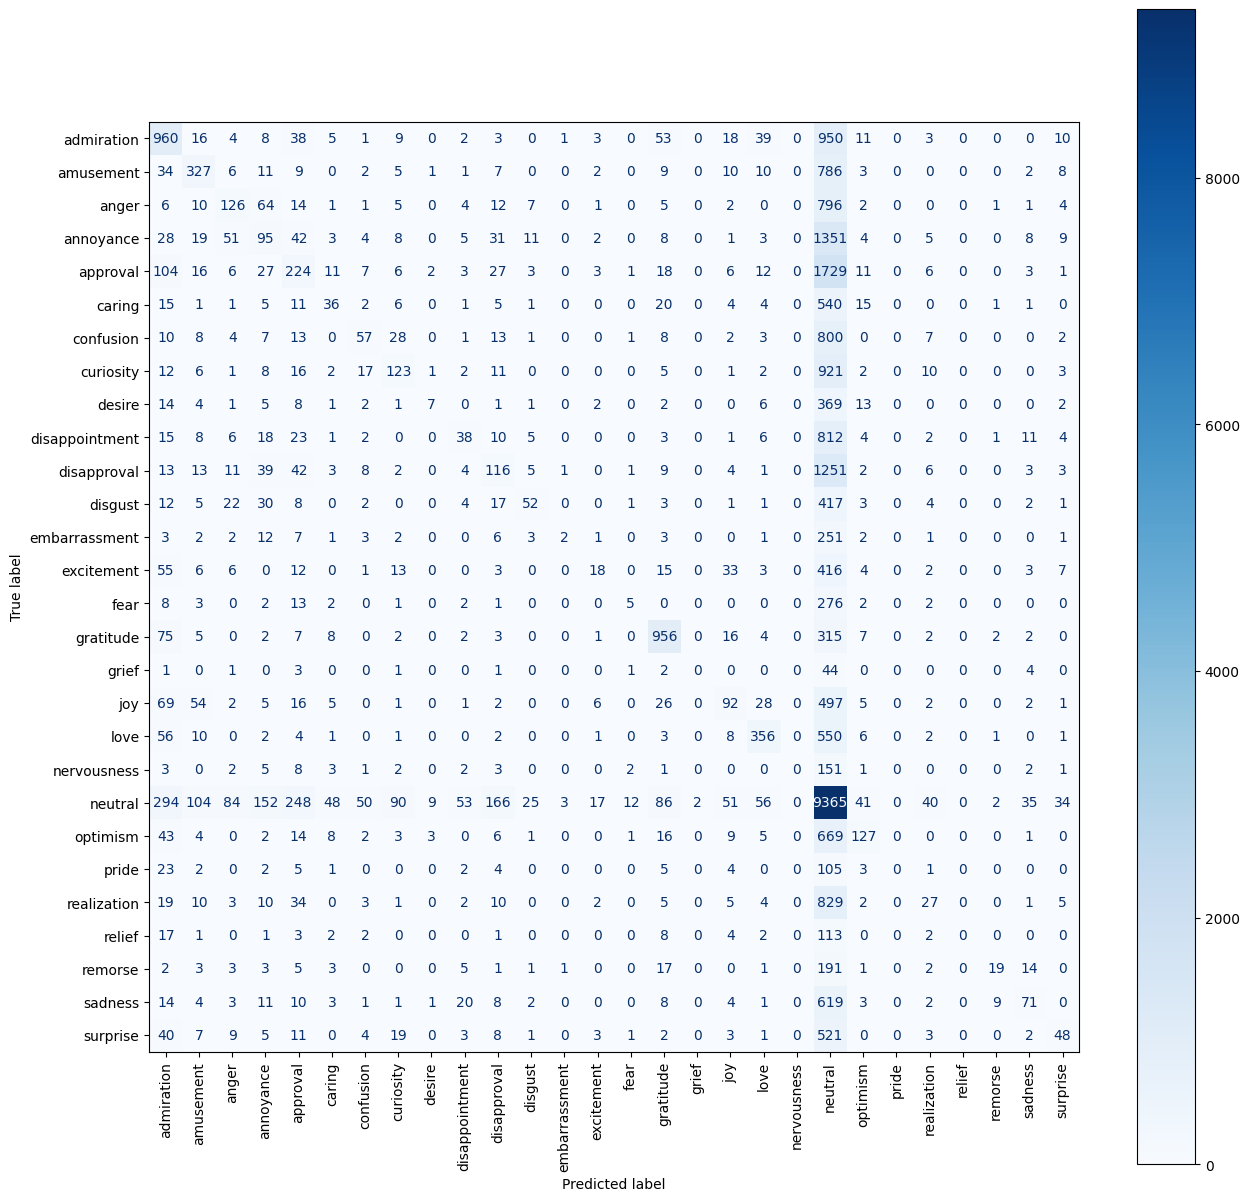

In [250]:
#BaseMNB
# generateConfusionMatrix(emotions_baseMNB_classifier, emotions_test, emotions_baseMNB_pred)
createPrecisionReport(modelName = "base_MultinomialNB", emotions_pred = emotions_baseMNB_pred, sentiments_pred = sentiments_baseMNB_pred, emotions_classifier = emotions_baseMNB_classifier, sentiments_classifier = sentiments_baseMNB_classifier)